накинем возможный алгоритм

In [1]:
import numpy as np
import os
import sys
from pathlib import Path
from importlib import reload
sys.path.append(os.getcwd())
sys.path.append(os.getcwd() + '/src')
sys.path.append(os.getcwd() + '/cacheing')
sys.path.append(os.getcwd() + '/cacheing/benchmark')

%load_ext autoreload
%autoreload 2


# random testcases

In [4]:
%load_ext autoreload
%autoreload 2

from dataset_generator import generate
t = 50_000
n = 500
cache_length = 100

dataset = generate(n, t, 0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [218]:
from importlib import reload
import LRU_algorithm as LRU
LRU = reload(LRU)

LRU_test_list  = [LRU.LRUCacheItem(i, f"item {i}") for i in range(n)]

cache = LRU.LRUCache(length=cache_length, delta=5, verbose = True)

for index in dataset:
    item = LRU_test_list[index]
    cache.getItem(item)
print(f"page fault rate: {cache.return_verbose()['loads'] / t}")

page fault rate: 0.78954


In [219]:
from importlib import reload 
import bandit_new as BDN
BDN = reload(BDN)
cache = BDN.BanditCache(capacity=  cache_length, history_capacity=  cache_length * 3, 
                                verbose = True, eps1 = 0.1, eps2 = 10)
dataset = generate(n, t, 0)
for index in dataset:
    key = index
    val =  10
    cache[key] = val
print(f"page fault rate: {cache.return_verbose()['loads'] / t}")
print(f"page reuse rate: {cache.return_verbose()['reuse'] / t}")

/Users/ilgam/my_files/work/online_optimization/code/src/bandit_new.py:74: RuntimeWarning: overflow encountered in exp
  val =( self.sum/self.size )* np.exp(-(np.log(self.iteration /item.last_use))*eps / (self.sum/self.size))
/Users/ilgam/my_files/work/online_optimization/code/src/bandit_new.py:97: RuntimeWarning: invalid value encountered in scalar divide
  self._cache_meta[_key].val /= self.sum


page fault rate: 0.79208
page reuse rate: 0.60102


In [64]:
import second_chance as SC
dataset = generate(n, t, 0)
indices = [i for i in dataset]
SC = reload(SC)
print(f"page fault rate: {SC.printHitsAndFaults(indices, cache_length) / t}")


page fault rate: 0.8965666666666666


In [87]:
from importlib import reload
import dummy as DM
DM = reload(DM)

LRU_test_list  = [LRU.LRUCacheItem(i, f"item {i}") for i in range(n)]

cache = DM.DummyCache(length=cache_length, delta=5, verbose = True)

dataset = generate(n, t, 0)
for index in dataset:
    item = LRU_test_list[index]
    cache.getItem(item)
print(f"page fault rate: {cache.return_verbose()['loads'] / t}")

page fault rate: 0.79046


In [66]:
from importlib import reload
import belady_min as BM
BM = reload(BM)

BM_test_list  = [BM.LRUCacheItem(i, f"item {i}") for i in range(n)]

dataset = generate(n, t, 0)
indices = [i for i in dataset]
cache = BM.BeladyMin(cache_length, order = indices, verbose = True)


for index in indices:
    item = BM_test_list[index]
    cache.getItem(item)
print(f"page fault rate: {cache.return_verbose()['loads'] / t}")

page fault rate: 0.6002333333333333


# ML

In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from network import NetCache, NetCacheItem

emb_dim = 10
Net_test_list  = [NetCacheItem(i, f"item {i}") for i in range(n)]

dataset = generate(n, t, 0)
cache = NetCache(cache_length, n, emb_dim, verbose = True)
# cache = LRU.LRUCache(length=cache_length, delta=5, verbose = True)

for index in dataset:
    item = Net_test_list[index]
    cache.getItem(item)
print(f"page fault rate: {cache.return_verbose()['loads'] / t}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'n' is not defined

In [74]:

cache.model(torch.IntTensor([3]), torch.IntTensor([2]))

(tensor([[-0.1386, -0.3121, -0.3044, -0.4159, -0.2095,  0.0993,  0.1792,  0.5636,
           0.4363,  0.1543]]),
 tensor(-0.5776, grad_fn=<NegBackward0>))

In [50]:
len(requests)

500

In [60]:
requests_len = 10

import numpy as np
N = 1000
P = 0
K = 5 # cache size

# requests = np.concatenate([list(range(N)) for i in range(10)])
# requests = [np.random.randint(0, N) for i in range(1000)]
with open('/Users/ilgam/my_files/work/online_optimization/code/LeCaR/code/data.txt', 'r') as f:
    a = f.read()
    requests = list(map(int, a.split('\n')))



print("LRU:")
miss = 0
cache = [None for i in range(K)]
for req in requests:
    if req in cache:
        cache.remove(req)
        cache.append(req)
    else:
        miss += 1
        del cache[0]
        cache.append(req)
print(f'miss rate: {miss / len(requests)}')

print("observe cache:")
miss = 0
cache = [None for i in range(K)]
for pos in range(len(requests)):
    observations = requests[pos: min(pos + P, len(requests))]
    req = requests[pos]
    # print(cache, req)
    if req in cache:
        cache.remove(req)
        cache.append(req)
    else:
        if None in cache:
            del cache[0]
        else:
            C_obs = set(cache) - set(observations)
            if len(C_obs) != 0: # есть элемент для удаления
                ind = 0
                while not (cache[ind] in C_obs):
                    ind += 1
                # нашли индекс для удаления
                del cache[ind]
            else: # все элементы в кэше запрошены на будущее. удаляем то, которое запрошено на более позднее время
                _key = None
                mmin = -np.inf
                for key in cache: 
                    try:
                        ind = observations.index(key)
                    except:
                        ind = np.inf  #not found
                    if ind > mmin:
                        mmin = ind
                        _key = key
                
                cache.remove(_key)
        cache.append(req)
        miss += 1

print(f"misses: {miss / len(requests)}")


        

LRU:
miss rate: 0.562
observe cache:
misses: 0.562


# policies

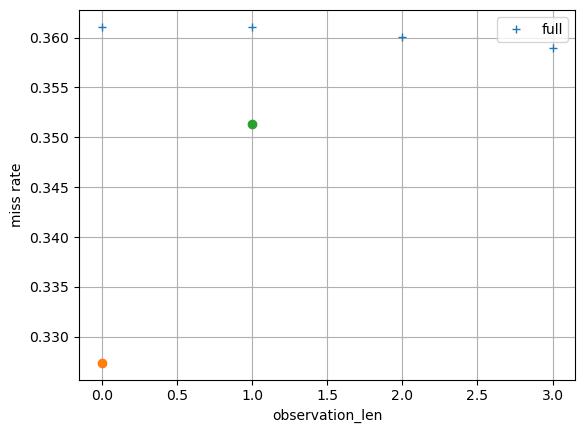

(90, 0.9899831701346389) (78, 0.9899831701346389) (70, 0.9899831701346389) 1000 0.9894115831041584


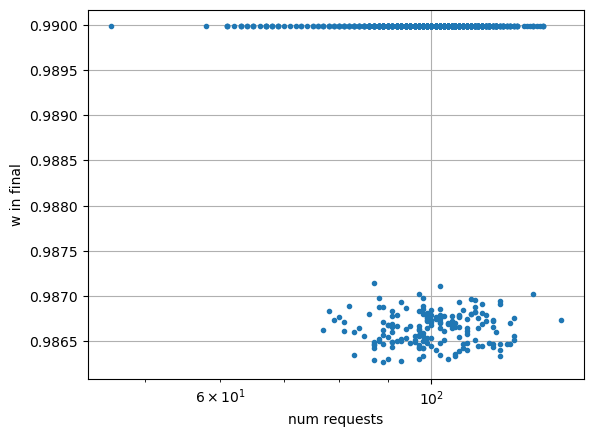

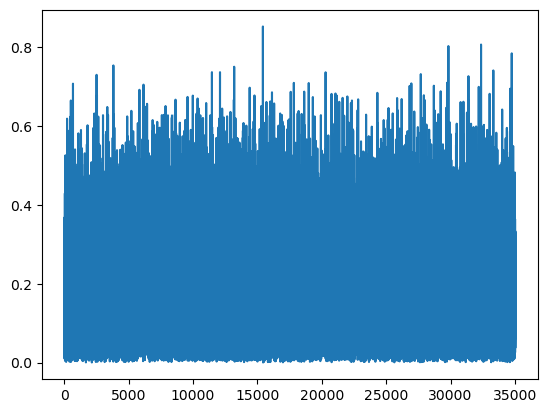

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import dataset_generator as generators
from collections import Counter
from proposed_algos import cache_obs, cache_prob, cache_prob_mul, cache_prob_mul_separate

t, N, K, disperce, cycles = 100_000, 1000, 100, 0.1, 2
shift_time = t // cycles
# dataset = generate(N, t, 0)
# requests = list(dataset)
# seed = np.random.randint(1000)

requests = list(generators.generate_with_shift(N, t, shift_time, disperce, eps = 0.01))
# requests = list(generators.generate_zipf(t, 1.1, random_seed = 0))

p_list = range(0, 4, 1)
miss_rates = [cache_obs(requests, K, p, N) for p in p_list]
# miss_prob_sep, weights_sep, p_for_step_sep = cache_prob_mul_separate(requests, K,  N,
#                  gamma=1.52e-03, beta = 1.25e+00)
# miss_prob = [miss_prob_sep]

miss_prob_mul, weights_mul, p_for_step = cache_prob_mul(requests, K,  N,
            1.00e-06, beta = 1.09e+00)
miss_prob_mul = [miss_prob_mul]
# plt.plot(p_list, miss_rates_prob, label = "prob")
plt.plot(p_list, miss_rates, '+', label = 'full')
plt.plot(0, miss_prob, 'o')
plt.plot(1, miss_prob_mul, 'o')
plt.legend()
plt.grid()
plt.ylabel("miss rate")
plt.xlabel("observation_len")
plt.show()

counts = Counter(requests)
# tmp = {key: (counts[key], weights[key]) for key in counts.keys()}
# print(tmp[1], tmp[2], tmp[3], len(tmp), np.mean(list(weights.values())))
tmp = {key: (counts[key], weights_mul[key]) for key in counts.keys()}
print(tmp[1], tmp[2], tmp[3], len(tmp), np.mean(list(weights_mul.values())))

def plot_counts(w):
    plt.plot(counts.values(), w.values(), '.')
    plt.xscale('log')
    plt.grid()
    plt.xlabel('num requests')
    plt.ylabel('w in final')
    plt.show()
    
# plot_counts(weights)
plot_counts(weights_mul)
plt.plot(p_for_step)


LRU result: 0.352609
prod missmap0.355939
prod missmap
mean alive prob: 0.389997875


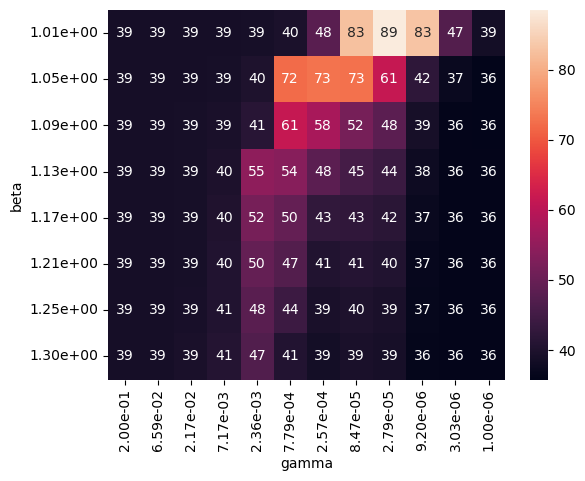

best res: 0.357913
             with paramenters: gamma=1.00e-06, beta = 1.05e+00
summ missmap


In [79]:
import plot_hitmap as hitmaps
show_plot = True

t, N, K, disperce, cycles = 1_000_000, 1000, 100, 0.1, 6
shift_time = t // cycles
# dataset = generate(N, t, 0)
# requests = list(dataset)
# seed = np.random.randint(1000)
requests = list(generators.generate_with_shift(N, t, shift_time, disperce, eps = 0.01))

# requests = list(generators.gen erate_zipf(t, 1.1, random_seed = 0))
print(f"LRU result: {cache_obs(requests, K, 0, N)}")
print(f"prod missmap{cache_prob_mul_separate(requests, K, N,)[0]}")
print('prod missmap')
df = hitmaps.plot_hit_map_mul(requests, cache_prob_mul, K, N, show_plot = show_plot)
# print("prod separate missmap")
# df = hitmaps.plot_hit_map_mul(requests, cache_prob_mul_separate, K, N, show_plot = show_plot)
print("summ missmap")
# df = hitmaps.plot_hit_map(requests, cache_prob, K, N, show_plot = show_plot)


In [63]:
1.05 * (1 - 9.2e-6) ** 1000

1.0403842560130692

mean alive prob: 0.356300625


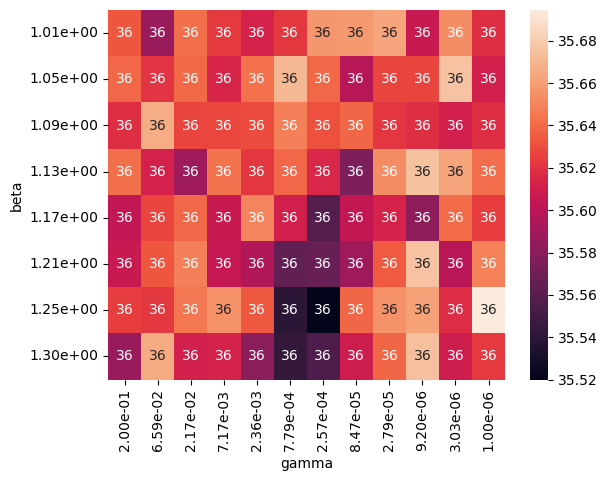

best res: 0.3552
             with paramenters: gamma=2.57e-04, beta = 1.25e+00
summ missmap


In [30]:
df = hitmaps.plot_hit_map_mul(requests, cache_prob_mul, K, N, show_plot = show_plot)
# print("prod separate missmap")
# df = hitmaps.plot_hit_map_mul(requests, cache_prob_mul_separate, K, N, show_plot = show_plot)
print("summ missmap")

In [163]:
import itertools
from tqdm import tqdm
import pickle

# пройдемся по разным параметрам датасета и найдем зависимость параметов алгоритма 
#  от характерных величин для датасета.
#  это: длительность запросов, количество элементов кеша, 
# размеры кеша, дисперсия запросов и число циклов в кеше

param_grid = {
    "t": [300_000],# 200_000],
    "N": [1000], # 10000],
    "K":  [50], # 400],
    'disperce': [0.1, 0.05],
    'cycles': [2, 4, 10, 20]
}

names = param_grid.keys()
combinations = itertools.product(*param_grid.values())

p_list = range(0, 1, 1)
rezult = {}
for elem in tqdm(combinations):
    t, N, K, disperce, cycles = elem
    print(t, N, K, disperce, cycles)
    shift_time = t // cycles
    requests = list(generators.generate_with_shift(N, t, shift_time, disperce, eps = 0.01))
    # rez_dataframe = hitmaps.plot_hit_map_mul(requests, cache_prob_mul, K, N)
    LRU_miss_rate = cache_obs(requests, K, 0, N)
    rez_miss_rate = cache_prob_mul_separate(requests, K, N)[0]
    print(f"LRU_miss_rate: {LRU_miss_rate}    alg_miss_rate: {rez_miss_rate}")
    rezult[elem] = [{"LRU_miss_rate": LRU_miss_rate, 'cache_prob_mul_separate_miss_rate': rez_miss_rate}]

experiments_data = ["test algorithm with autoparameters",\
             "LRU_miss_rate, cache_prob_mul_separate_miss_rate", rezult]
with open('auto_parameters.pkl', 'wb') as file:
    pickle.dump(experiments_data, file)

0it [00:00, ?it/s]

300000 1000 50 0.1 2


1it [00:43, 43.99s/it]

LRU_miss_rate: 0.8426566666666667    alg_miss_rate: 0.8351566666666667
300000 1000 50 0.1 4


2it [01:29, 44.99s/it]

LRU_miss_rate: 0.84256    alg_miss_rate: 0.8391633333333334
300000 1000 50 0.1 10


2it [01:37, 48.79s/it]


KeyboardInterrupt: 

## algorithms comparison


In [1]:
with open('first_exp.pkl', 'rb') as file:
    mul_independent = pickle.load(file)

with open('second_exp.pkl', 'rb') as file:
    mul = pickle.load(file)

NameError: name 'pickle' is not defined

In [346]:
from collections import defaultdict
def best_rez(df):
    return np.min(df.values)
def acceleration(lru_best, alg_best):
    return ((1 - alg_best) - (1 - lru_best))/(1 - lru_best)

mul_dict = mul[2]
indep_dict = mul_independent[1]

keys = np.array(list(mul_dict.keys() ) )

dicts = [mul_dict, indep_dict]
accelerations = [0, 0]
tmp_dict = defaultdict(lambda : {})
for i, d in enumerate(dicts):
    tmp = [d[tuple(key)] for key in keys]
    accelerations[i] = [acceleration(elem[0]['LRU_miss_rate'], best_rez(elem[1])) for elem in tmp]
    # for j, key in enumerate(keys):

        # tmp_dict[key][i] = accelerations[i][j]


<Figure size 1000x2000 with 0 Axes>

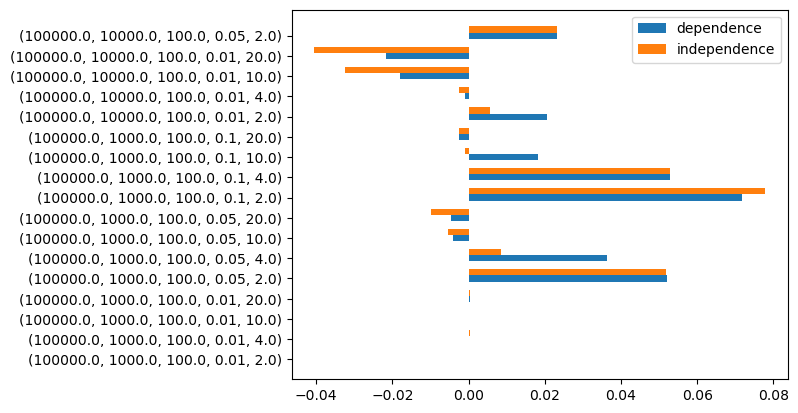

In [360]:
fig = plt.figure(figsize=(10, 20))
fig, ax = plt.subplots()

accelerations = np.array(accelerations)
category_ind = keys[:, 2] == 100
category = keys[category_ind]
mul_accel = accelerations[0][category_ind]
indep_accel = accelerations[1][category_ind]
ind = np.arange(len(category))
width = 0.3
a = ax.barh(ind, mul_accel, width)
b = ax.barh(ind + width, indep_accel,  width)
ax.set_yticks(ind)
ax.set_yticklabels([tuple(tt) for tt in category])
ax.legend((a[0], b[0]), ['dependence', 'independence'], loc='upper right')

In [344]:
np.array(df['category'].values)[:, 2]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [2]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame()

plt.figure(figsize=(20, 20))
# fig, ax = plt.subplots()
df['category'] = keys
df['mul'] = accelerations[0]
df['independent'] = accelerations[1]
df['category'] = df['category']

# df = df.iloc[df['category'][2] == 100]
df.plot.barh(x='category', width = 0.5, fig = fig)
plt.show()


NameError: name 'plt' is not defined

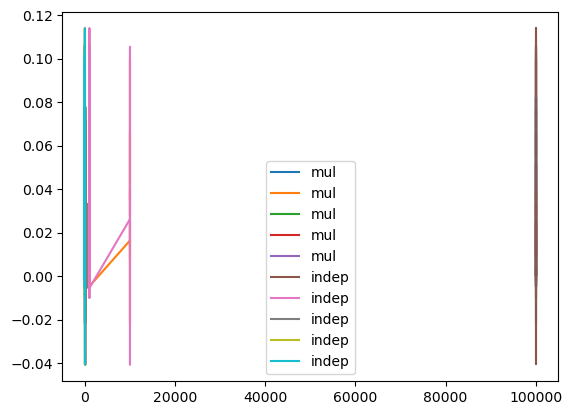

In [276]:
plt.plot(keys, accelerations[0], label = "mul")
plt.plot(keys, accelerations[1], label = "indep")
plt.legend()
plt.show()

trace missmap, len = 1000


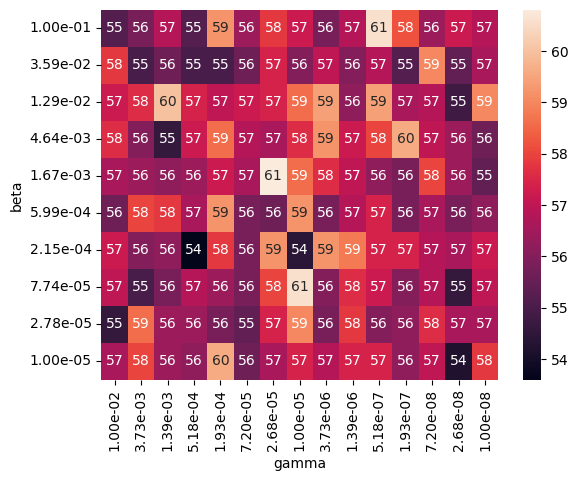

In [899]:
print('trace missmap, len = 1000')
K = 5
with open('/Users/ilgam/my_files/work/online_optimization/code/LeCaR/code/data.txt', 'r') as f:
    a = f.read()
    requests = list(map(int, a.split('\n')))
    # requests = list(np.concatenate([requests for _ in range(10)]))
plot_hit_map(requests)

## another

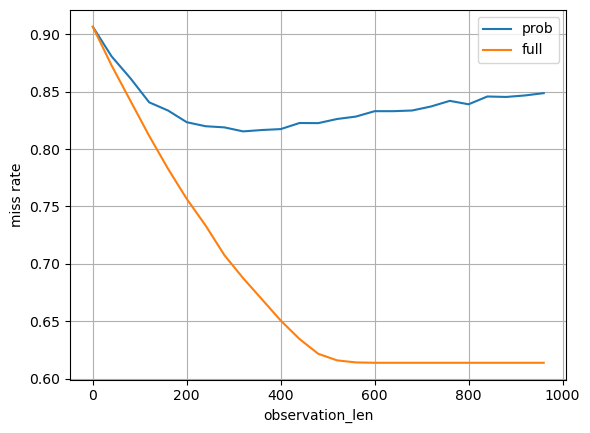

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from dataset_generator import generate
t = 10_000
N = 1000
K = 100

# dataset = generate(N, t, 0)
# requests = list(dataset)



# requests = list(np.concatenate([list(range(N)) for i in range(10)]))
requests = [np.random.randint(0, N) for i in range(t)]
# with open('/Users/ilgam/my_files/work/online_optimization/code/LeCaR/code/data.txt', 'r') as f:
#     a = f.read()
#     requests = list(map(int, a.split('\n')))

p_list = range(0, 1000, 40)
miss_rates_prob = [cache_obs_prob(requests, K, p, N) for p in p_list]
miss_rates = [cache_obs(requests, K, p, N) for p in p_list]
plt.plot(p_list, miss_rates_prob, label = "prob")
plt.plot(p_list, miss_rates, label = 'full')
plt.legend()
plt.grid()
plt.ylabel("miss rate")
plt.xlabel("observation_len")
plt.show()


# постановка с 2 последовательностями запросов.

Пусть есть две последовательности запросов. Рассмотрим два способа кэшировать их

1) в запросе из каждого запроса доступно по k последующих запросов. При выборе жертвы для удаления для страницы учитывается минимальный индекс, с которым страница входит в наблюдения запроса


In [106]:
def cache_obs_seq(requests_seq, K, P, N):
    # requests_seq -- массив последовательностей запросов. Для простоты рассмотрим последовательную обработку запросов
    #  страниц по большим запросам, когда кэш поочередно обрабатывает запросы с последовательностей
    # requests_seq is np.array of shape (num_requests, len_requests)
    miss = 0
    cache = [None for i in range(K)]
    for pos in range(len(requests_seq[0])):
        for it in range(len(requests_seq)):
            observations = requests_seq[:, pos: min(pos + P, len(requests_seq[0]))].tolist()
            req = requests_seq[it][pos]
            # print(cache, req)
            if req in cache:
                cache.remove(req)
                cache.append(req)
            else:
                if None in cache:
                    del cache[0]
                else:
                    obs_set = set()
                    for el_ in observations:
                        obs_set.update(el_)
                    C_obs = set(cache) - obs_set
                    if len(C_obs) != 0: # есть элемент для удаления
                        ind = 0
                        while not (cache[ind] in C_obs):
                            ind += 1
                        # нашли индекс для удаления
                        del cache[ind]
                    else: # все элементы в кэше запрошены на будущее. удаляем то, которое запрошено на более позднее время
                        _key = None
                        mmin = -np.inf
                        for key in cache: 
                            try:
                                ind = np.min([ (observations[req_num].index(key) if key in observations[req_num] else np.inf) for req_num in range(len(requests_seq)) ])
                            except:
                                ind = np.inf  #not found
                            if ind > mmin:
                                mmin = ind
                                _key = key
                        
                        cache.remove(_key)
                cache.append(req)
                miss += 1
    return miss / len(requests)

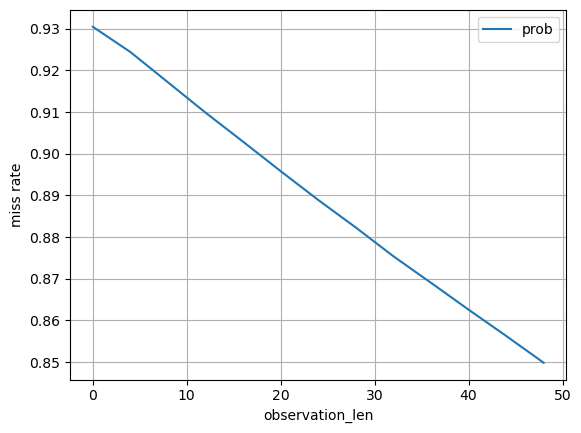

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from dataset_generator import generate
t = 10_0000
N = 1000
K = 70

# dataset = generate(N, t, 0)
# requests = list(dataset)



# requests = list(np.concatenate([list(range(N)) for i in range(10)]))
requests1 = [np.random.randint(0, N) for i in range(t)]
requests2 = [np.random.randint(0, N) for i in range(t)]
requsets_seq = np.stack([requests1, requests2], axis = 0)
print(requsets_seq.shape)
# with open('/Users/ilgam/my_files/work/online_optimization/code/LeCaR/code/data.txt', 'r') as f:
#     a = f.read()
#     requests = list(map(int, a.split('\n')))

p_list = range(0, 51, 4)
miss_rates_seq = [cache_obs_seq(requsets_seq, K, p, N) / 2 for p in p_list]
plt.plot(p_list, miss_rates_seq, label = "prob")
plt.legend()
plt.grid()
plt.ylabel("miss rate")
plt.xlabel("observation_len")
plt.show()


## Моделирование запросов с таблицами

Заводим таблицы, для заводим несколько страниц.

In [64]:
class FILE:
    def __init__(self, id, parameter = 1.25):
        self.id = id
        self.param = parameter
    def request(self, num_pages):
        return [(self.id, num) for num in np.random.zipf(self.param, num_pages)]
    
class Dataset:
    def __init__(self, num_files):
        self.files = [FILE(i,) for i in range(num_files)]
        self.file_weight = [1.]
        self.num_files = num_files
    def request(self, min_pages = 10, max_pages = 20):
        # this is one request for files
        num_files = np.random.choice(range(1, self.num_files + 1))
        num_pages = np.random.choice(range(min_pages, max_pages))
        files = np.random.choice(self.files, size=num_files, replace=True)
        pages = np.concatenate([file.request(np.random.choice(range(1, num_pages))) for file in files])
        return pages

request получаем на 1 шаг. после этого используем алгоритм кеширования и замещаем страницы. Hit rate считается на момент получения request

# Trash


test samples coeff

[-0.14045858]
[-0.11073768]


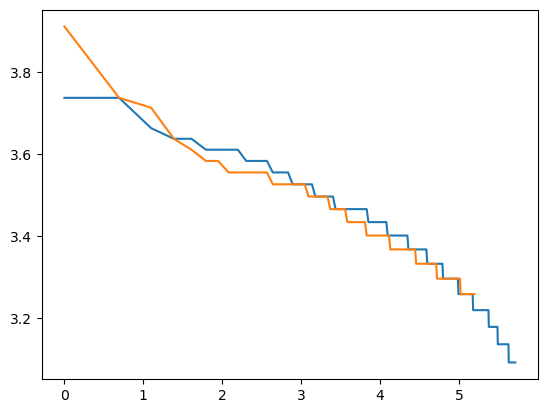

In [114]:
def get_coeff(requests, verbose = True):
    counts = Counter(requests)
    mmax = max(counts.values())//2
    counts = dict(filter(lambda x: x[1] > mmax, counts.items()))
    counts = sorted(list(counts.values()), key= lambda x : -x)
    X = np.log(np.arange(1, len(counts) + 1)).reshape(-1, 1)
    y = np.log(counts)
    # y = y / np.max(y)

    plt.plot(X, y)

    model = LinearRegression().fit(X, y)
    print(model.coef_)

import dataset_generator as generators
from collections import Counter
t, N, K, disperce, cycles = 10_000, 400, 50, 0.1, 4
shift_time = t // cycles

requests0 = list(generators.generate_with_shift(N, t, shift_time = shift_time, disperse = 0.05, eps = 0.01))
requests1 = list(generators.generate_with_shift(N, t, shift_time = shift_time, disperse = 0.5, eps = 0.99))
# requests2 = list(generators.generate_with_shift(N, t, shift_time = shift_time, disperse = 0.1, eps = 0.01))

get_coeff(requests0)
get_coeff(requests1)
# get_coeff(requests2)

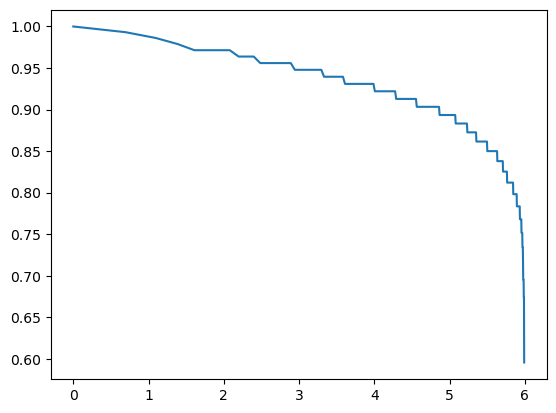

[-0.04978059]


In [66]:
import dataset_generator as generators
from collections import Counter
t, N, K, disperce, cycles = 10_000, 400, 50, 0.01, 4
shift_time = t // cycles

requests = list(generators.generate_with_shift(N, t, shift_time, disperce, eps = 0.01))
counts = Counter(requests)
counts = dict(filter(lambda x: x[1] > 1, counts.items()))
counts = sorted(list(counts.values()), key= lambda x : -x)
X = np.log(np.arange(1, len(counts) + 1)).reshape(-1, 1)
y = np.log(counts)
y = y / np.max(y)

plt.plot(X, y)
plt.show()
model = LinearRegression().fit(X, y)
print(model.coef_)

## автоподбор параметров

In [108]:
sum(sorted(p_s)[:-50])

0.9251265659900834

0 0.5
1 1
2 2
3 3


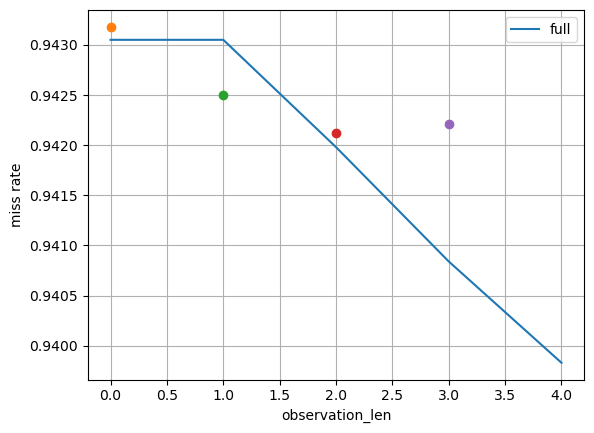

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import dataset_generator as generators
from collections import Counter
from proposed_algos import cache_obs, cache_prob, cache_prob_mul, cache_prob_mul_separate, cache_fixed_prob

t, N, K, disperce, cycles = 1_00_000, 1000, 50, 0.2, 6
shift_time = t // cycles
# dataset = generate(N, t, 0)
# requests = list(dataset)
# seed = np.random.randint(1000)

# requests = list(generators.generate_with_shift(N, t, shift_time, disperce, eps = 0.01))
requests, p_s = generators.generate_distribution(N, t, 10)
# requests = list(generators.generate_zipf(t, 1.1, random_seed = 0))

p_list = range(0, 5, 1)
miss_rates = [cache_obs(requests, K, p, N) for p in p_list]
plt.plot(p_list, miss_rates, label = 'full')

weights_sep = 0
for i, pow in enumerate([0.5, 1, 2, 3]):
    print(i, pow)
    miss_fixed_rates, weights_sep = cache_fixed_prob(requests, K,N, pow, gamma = 0.005)
    plt.plot(i, miss_fixed_rates, 'o')



plt.legend()
plt.grid()
plt.ylabel("miss rate")
plt.xlabel("observation_len")
plt.show()


0 6
1 7
2 8


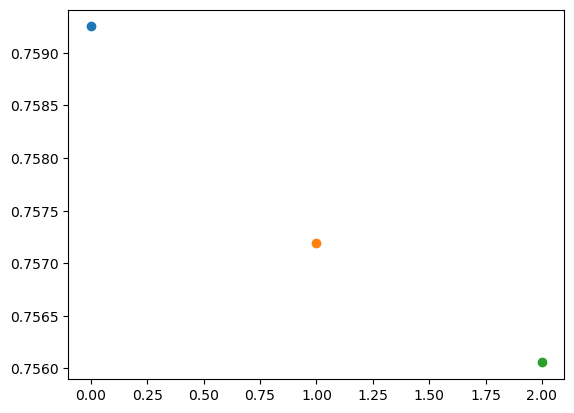

In [98]:
for i, pow in enumerate([6, 7, 8]):
    print(i, pow)
    miss_fixed_rates, weights_sep = cache_fixed_prob(requests, K,N, pow, gamma = 0.005)
    plt.plot(i, miss_fixed_rates, 'o')

In [99]:
miss_fixed_rates

0.756057

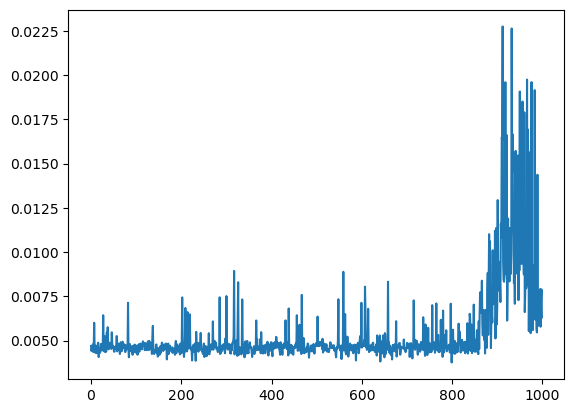

In [100]:
plt.plot(weights_sep)

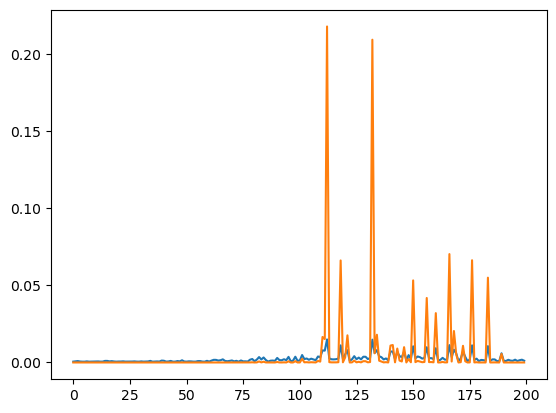

In [105]:
to = -200
tmp = weights_sep ** 2
tmp = tmp / np.sum(tmp)
plt.plot(tmp[to:])

tmp = weights_sep ** 8
tmp = tmp / np.sum(tmp)
plt.plot(tmp[to:])

задача на подумать

miss_rate >= 1 - sup(p bests)

какая нижняя граница если моделируем зависимость от предыдущих запросов. Для начала можем рассмотреть марковскую цепь. Если не зависит от предыдущих, то просто храним K элементов с наибольшими вероятностями, 

Также получить верхние оценки на работу алгоритма при этой функции сравнения.

Рассмотреть сравнение удаляемой страницы с несколькими последними страницами.

